# Project 12: Text-to-text translation
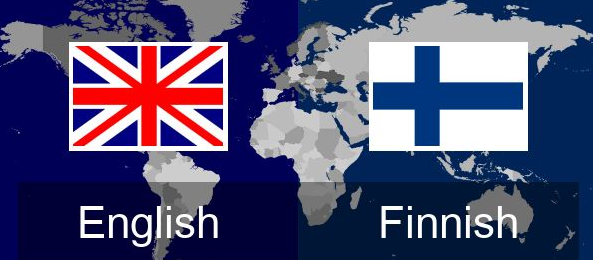

# Team:
## Arif, Md Abdullah-Al Mamun, Ronald


### Project Rules:
- Use object Oriented Programming.
- Use Pytorch-Lightning. 
- Do not use pre-trained models.
- ○	Create three pytorch classes:
■	First Class for loading and preprocessing the data
■	Second Class for dataset
■	Third Class for building the model.


### Project Protocol:  
- Select one of the problems above
- Download the dataset of the selected problem.
- Read/load the problem’s dataset.
- Identify the features and the targets.
- Perform the necessary preprocessing steps (if needed).
- Split data into Training, Validation, and Testing sets (if needed).
- Design the architecture for building the model.
- Define the loss function and the performance measures.
- Train and Validate the model using (Train and validation sets).
- Plot the loss/performance of Train and Validation using both tensorboard and matplotlib.
- Evaluate the model using the Test set.


## Target of the project:
### Our goal is to develop a deep learning model for translating different languages. However, our current focus is on English to Finnish translation.

## About Dataset

Dataset collected from Tatoeba repository https://tatoeba.org/en/downloads . it consists of two files :
- eng.txt: Contains Enlish sentences in each lines. Total: 100248 English sentenes
- fin.txt: Contains FInnish sentences in each lines. Total: 100248 Finnish sentenes

Tatoeba, an expansive assortment of example sentences with translations, caters specifically to foreign language learners and is provided free of charge. Supporting over 400 languages, its name derives from the Japanese phrase "tatoeba" (例えば), signifying "for example". This valuable resource thrives on the efforts of a dedicated community of volunteers who collaborate openly, with each contributor affectionately known as a "Tatoeban". Association Tatoeba, a French non-profit organization, oversees the project and sustains its operations through generous donations.
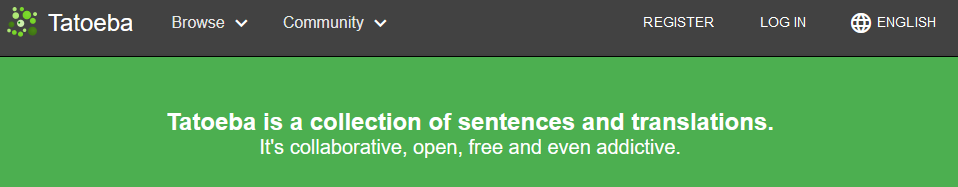

[Language Tree](attachment:image.png)
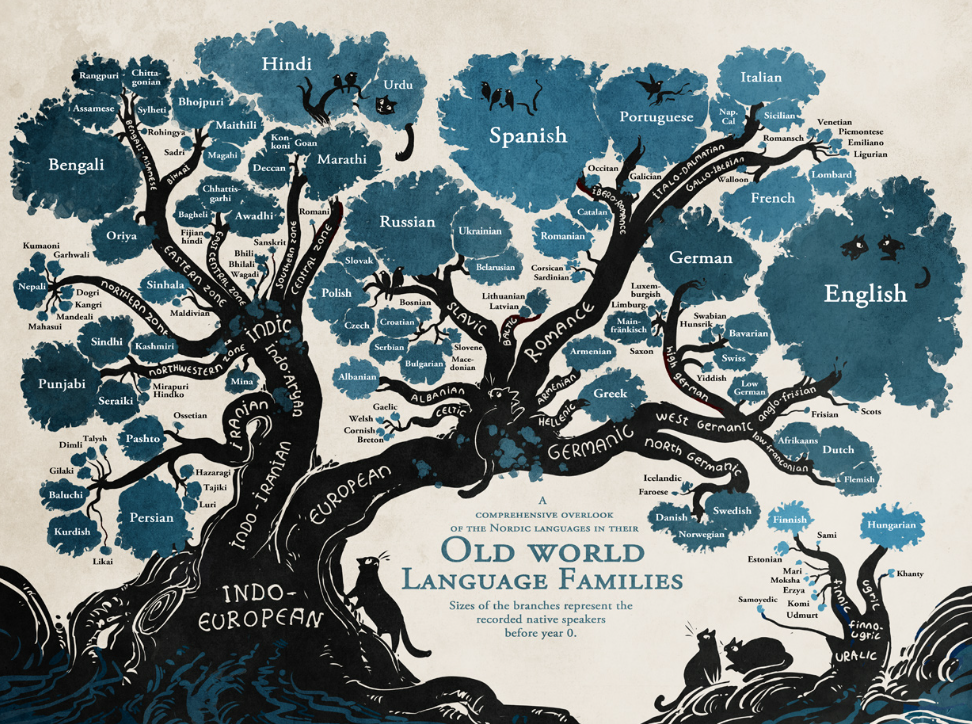


## Libraries

In [1]:
import collections
import matplotlib.pyplot as plt
import os
import pickle
import pytorch_lightning as pl
import random
import spacy  # for tokenization of Finnish
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.callbacks import RichProgressBar, EarlyStopping
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
from sklearn.model_selection import train_test_split
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import TensorBoard
from torch import LongTensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.metrics import bleu_score
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

# Loading data...

In [6]:
english_file = "./saved_results/eng.txt"
finnish_file = "./saved_results/fin.txt"

# Read the English and Finnish sentences from the data files
with open(english_file, "r", encoding="utf-8") as f:
    english_sentences = f.read().splitlines()

with open(finnish_file, "r", encoding="utf-8") as f:
    finnish_sentences = f.read().splitlines()

## Identify the features and the targets:


### 🍃 Features:  Source Language Text (English sentences)


###  🎯 Targets/labels: Target Language Text (Finnish sentences) 

In [7]:
import pandas as pd

en_df = pd.DataFrame({"English Sentence": english_sentences})

en_df

,English Sentence
0,Let's try something.
1,Let's try something.
2,Let's try something.
3,I have to go to sleep.
4,Muiriel is 20 now.
...,...
100243,I'm sick of taking the bus to work.
100244,It's a common symptom.
100245,Don't cut in when others are talking.
100246,"Free as in freedom, not as in free beer."


In [8]:
en_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100248 entries, 0 to 100247
Data columns (total 1 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   English Sentence  100248 non-null  object
dtypes: object(1)
memory usage: 783.3+ KB


In [9]:
en_df.describe()

,English Sentence
count,100248
unique,74359
top,You'll never know unless you try.
freq,212


In [10]:
fi_df = pd.DataFrame({"Finnish Sentence": finnish_sentences})

fi_df

,Finnish Sentence
0,Kokeillaanpa jotakin!
1,Koitetaanpas tätä!
2,Yritetään jotain.
3,Minun täytyy mennä nukkumaan.
4,Muiriel on nyt kaksikymmentä.
...,...
100243,Olen lopen kyllästynyt kulkemaan töissä bussilla.
100244,Se on yleinen oire.
100245,"Älä puhu päälle, kun muut puhuvat."
100246,"ʺFreeʺ niin kuin sanassa ʺfreedomʺ, ei niin ku..."


In [11]:
fi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100248 entries, 0 to 100247
Data columns (total 1 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Finnish Sentence  100248 non-null  object
dtypes: object(1)
memory usage: 783.3+ KB


In [13]:
english_sentences = len(en_df)
finnish_sentences = len(fi_df)

print(f"Total Number of Sentences: {english_sentences + finnish_sentences}")
print(f"Number of English Sentences: {english_sentences}")
print(f"Number of Finnish Sentences: {finnish_sentences}")

Total Number of Sentences: 200496
Number of English Sentences: 100248
Number of Finnish Sentences: 100248


In [35]:
unique_english_sentences = en_df["English Sentence"].nunique()
unique_finnish_sentences = fi_df["Finnish Sentence"].nunique()

print(f"Number of  Unique Sentences: {unique_english_sentences + unique_finnish_sentences}")
print(f"Number of Unique English Sentences: {unique_english_sentences}")
print(f"Number of Unique Finnish Sentences: {unique_finnish_sentences}")

Number of Sentences: 166118
Number of Unique English Sentences: 74359
Number of Unique Finnish Sentences: 91759


## Get the distribution of the data
- Define the distribution based on the plot

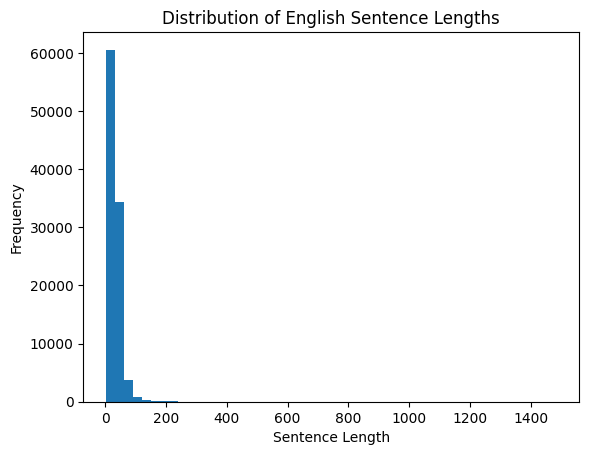

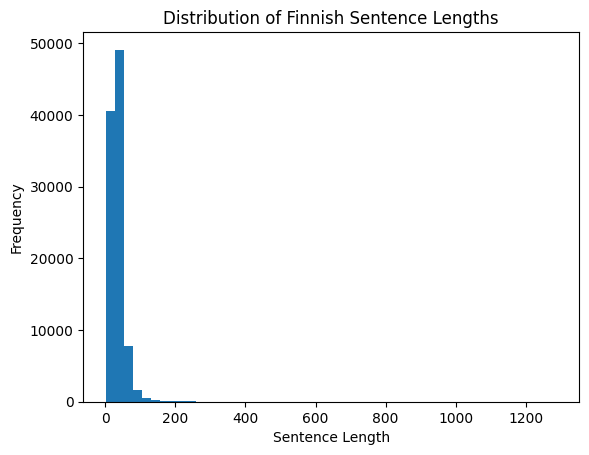

In [10]:
import matplotlib.pyplot as plt

# Calculate the lengths of English sentences
en_sentence_lengths = en_df["English Sentence"].apply(len)

# Create a histogram for the distribution of English sentence lengths
plt.hist(en_sentence_lengths, bins=50)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Distribution of English Sentence Lengths")
plt.show()

# Calculate the lengths of Finnish sentences
fi_sentence_lengths = fi_df["Finnish Sentence"].apply(len)

# Create a histogram for the distribution of Finnish sentence lengths
plt.hist(fi_sentence_lengths, bins=50)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Finnish Sentence Lengths")
plt.show()

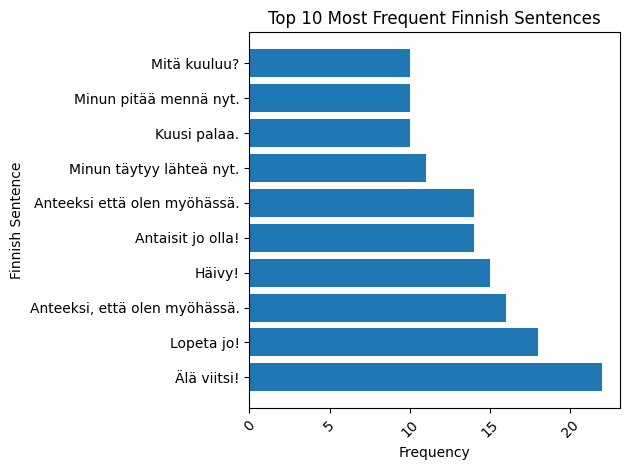

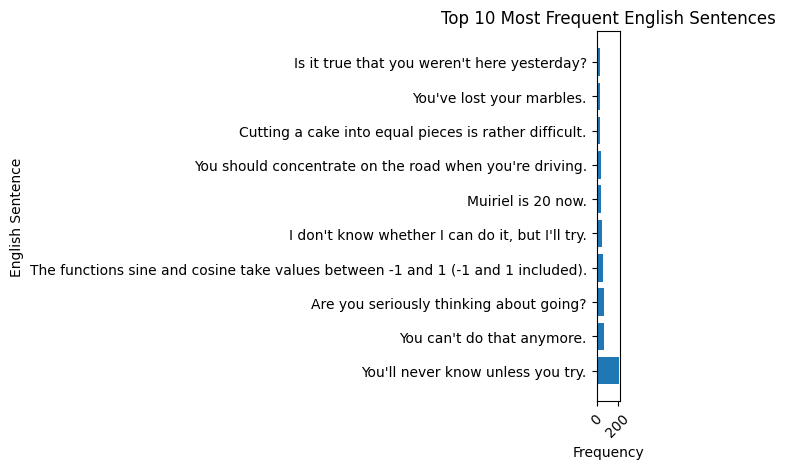

In [77]:
# Get the top 10 most frequent Finnish sentences
top_finnish_sentences = fi_df["Finnish Sentence"].value_counts().nlargest(10)

# Plot bar chart for the top 10 most frequent Finnish sentences
plt.barh(top_finnish_sentences.index, top_finnish_sentences.values)
plt.xlabel("Frequency")
plt.ylabel("Finnish Sentence")
plt.title("Top 10 Most Frequent Finnish Sentences")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Get the top 10 most frequent English sentences
top_english_sentences = en_df["English Sentence"].value_counts().nlargest(10)

# Plot bar chart for the top 10 most frequent English sentences
plt.barh(top_english_sentences.index, top_english_sentences.values)
plt.xlabel("Frequency")
plt.ylabel("English Sentence")
plt.title("Top 10 Most Frequent English Sentences")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


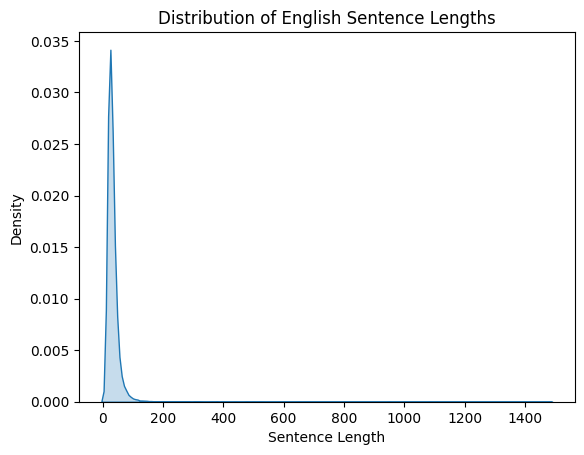

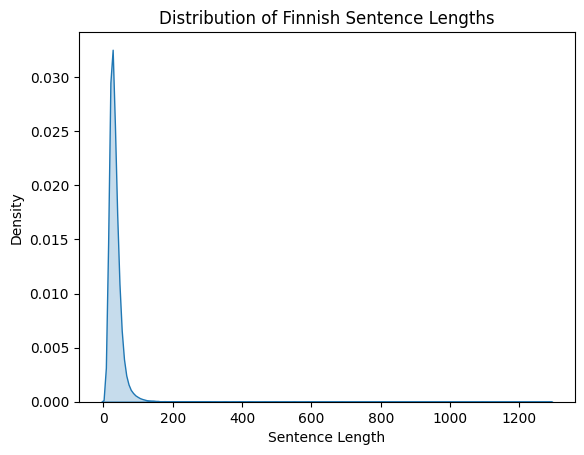

In [12]:
import seaborn as sns

# Calculate the lengths of English sentences
en_sentence_lengths = en_df["English Sentence"].apply(len)

# Create a KDE plot for the distribution of English sentence lengths
sns.kdeplot(data=en_sentence_lengths, fill=True)
plt.xlabel("Sentence Length")
plt.ylabel("Density")
plt.title("Distribution of English Sentence Lengths")
plt.show()

# Calculate the lengths of Finnish sentences
fi_sentence_lengths = fi_df["Finnish Sentence"].apply(len)

# Create a KDE plot for the distribution of Finnish sentence lengths
sns.kdeplot(data=fi_sentence_lengths, fill=True)
plt.xlabel("Sentence Length")
plt.ylabel("Density")
plt.title("Distribution of Finnish Sentence Lengths")
plt.show()


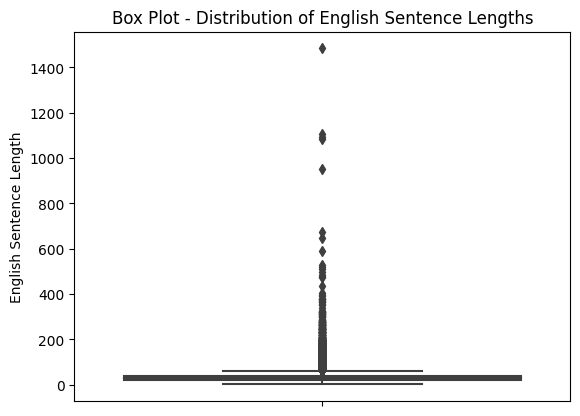

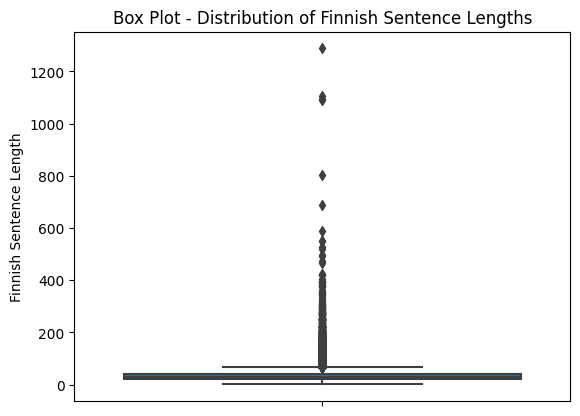

In [13]:
import seaborn as sns

# Calculate the lengths of English sentences
en_sentence_lengths = en_df["English Sentence"].apply(len)

# Create a box plot for the distribution of English sentence lengths
sns.boxplot(y=en_sentence_lengths)
plt.ylabel("English Sentence Length")
plt.title("Box Plot - Distribution of English Sentence Lengths")
plt.show()

# Calculate the lengths of Finnish sentences
fi_sentence_lengths = fi_df["Finnish Sentence"].apply(len)

# Create a box plot for the distribution of Finnish sentence lengths
sns.boxplot(y=fi_sentence_lengths)
plt.ylabel("Finnish Sentence Length")
plt.title("Box Plot - Distribution of Finnish Sentence Lengths")
plt.show()

## Settings and Initializations

In [48]:
import torch
from pytorch_lightning.loggers import TensorBoardLogger

# General settings
max_nr_of_input_pairs = 100000    # maximum size of input data 
# Language settings - English -> Finnish
source_lan_name = 'English'
source_lan_file = './saved_results/eng.txt'
target_lan_name = 'Finnish'
target_lan_file = './saved_results/fin.txt'

# Filter settings (to speed things up, we build a translator only for short sentences with specific prefixes)
max_sentence_length = 15
source_prefixes = ['i', 'he', 'she', 'you', 'we', 'they']

# Model architecture settings
emb_dim = 2048
hid_dim = 4096
dropout = 0.3

# Model training settings
batch_size = 384             # batch size for training
max_training_epochs = 125   # max number of epochs for model training

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")
    print("Number of GPU(s) available:", torch.cuda.device_count())
    print("Name of GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")

# Specify matmul precision and empty the cache
torch.set_float32_matmul_precision('medium')  # You can choose 'high' or 'low' depending on your preference
torch.cuda.empty_cache()

# Set up logging
logdir = 'logs'
tensorboard = TensorBoard(log_dir=logdir)

CUDA is available!
Number of GPU(s) available: 1
Name of GPU: NVIDIA GeForce GTX 1070


## Data loader class

In [49]:
class TranslationDataLoader():
    ''' This class reads and preprocesses the data '''
    def __init__(self, source_lan_name, target_lan_name, source_lan_file, target_lan_file, max_sentence_length = 10, max_nr_of_input_pairs = None, source_prefixes = None):
        # save attributes
        self.source_lan_name = source_lan_name
        self.target_lan_name = target_lan_name
        self.source_lan_file = source_lan_file
        self.target_lan_file = target_lan_file        
        # load, preprocess, tokenize, and split the data
        print('reading and preprocessing data')
        self.read_and_preprocess_data(max_nr_of_input_pairs, max_sentence_length, source_prefixes)
        print('tokenize data')
        self.tokenize_data()
        self.split_data()
        self.build_vocabs()

    def read_and_preprocess_data(self, max_nr_of_input_pairs, max_sentence_length, source_prefixes):
        source_data = []
        target_data = []
        with open(self.source_lan_file, 'r', encoding='utf-8') as f:
            source_data = f.read().splitlines()
        with open(self.target_lan_file, 'r', encoding='utf-8') as f:
            target_data = f.read().splitlines()
        print(f"Loaded {len(source_data)} sentence pairs")        
        # To lowercase and remove punctuation
        source_data = [sentence.lower().translate(str.maketrans('', '', string.punctuation)) for sentence in source_data]
        target_data = [sentence.lower().translate(str.maketrans('', '', string.punctuation)) for sentence in target_data]        
        # Replace "i'm" with "i am", "you're" with "you are", etc
        contractions = {"i'm":"i am", "you're":"you are", "he's":"he is", "she's":"she is", "it's":"it is", "we're":"we are", "they're":"they are", "you'll":"you will", "i'll":"i will", "they'll":"they will", "it'll":"it will", "he'll":"he will", "she'll":"she will", "isn't":"is not", "ain't":"is not"}
        for i in range(len(source_data)):
            for contraction, replacement in contractions.items():
                source_data[i] = source_data[i].replace(contraction, replacement)
                target_data[i] = target_data[i].replace(contraction, replacement)    
        # filter on sentence length
        valid_indices = [i for i in range(len(source_data)) if len(source_data[i].split()) <= max_sentence_length and len(target_data[i].split()) <= max_sentence_length]        
        source_data = [source_data[i] for i in valid_indices]
        target_data = [target_data[i] for i in valid_indices]        
        # filter on source prefix
        if source_prefixes is not None:
            valid_indices = [i for i in range(len(source_data)) if any(source_data[i].startswith(prefix) for prefix in source_prefixes)]
            source_data = [source_data[i] for i in valid_indices]
            target_data = [target_data[i] for i in valid_indices]            
        # filter on maximum input size
        if max_nr_of_input_pairs is not None:
            source_data = source_data[:max_nr_of_input_pairs]
            target_data = target_data[:max_nr_of_input_pairs]            
        # print how many left
        print(f"{len(source_data)} sentence pairs left after filtering")
        # zip into tuples
        self.data = list(zip(source_data, target_data))
        # show 3 random examples
        examples = random.sample(self.data, 3)
        for i, (source, target) in enumerate(examples, start=1):
            print(f" example {i}:\n  {source}\n  {target}")

    def get_tokenizer(self, lan):
        if lan == 'English':
            return spacy.load('en_core_web_sm')
        elif lan == 'Finnish':
            return spacy.load('fi_core_news_sm')         
        elif lan == 'Dutch':
            return spacy.load('nl_core_news_sm')
        else:
            raise ValueError('Unsupported source language')
            
    def tokenize_data(self):
        # unzip
        source_data, target_data = zip(*self.data)
        # load tokenizers
        spacy_source = self.get_tokenizer(self.source_lan_name)
        spacy_target = self.get_tokenizer(self.target_lan_name)                
        # tokenize sentences
        print(" tokenizing source")
        source_tokenized = [ ['<sos>'] + list(map(str, doc)) + ['<eos>'] for doc in spacy_source.pipe(source_data)]
        print(" tokenizing target")
        target_tokenized = [ ['<sos>'] + list(map(str, doc)) + ['<eos>'] for doc in spacy_target.pipe(target_data)]
        # zip back into tuples
        self.data = list(zip(source_tokenized, target_tokenized))
        
    def split_data(self, test_size=0.2, val_size=0.25):
        self.train_val_data, self.test_data = train_test_split(self.data, test_size=test_size)
        self.train_data, self.val_data = train_test_split(self.train_val_data, test_size=val_size)

    def build_vocabs(self):
        self.source_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        self.target_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}       
        # build vocab for source language
        source_words = [word for sentence in self.train_data for word in sentence[0] if word not in self.source_vocab]
        source_words = list(set(source_words))  # get unique words
        self.source_vocab.update({word: idx for idx, word in enumerate(source_words, start=len(self.source_vocab))})
        # build vocab for target language
        target_words = [word for sentence in self.train_data for word in sentence[1] if word not in self.target_vocab]
        target_words = list(set(target_words))  # get unique words
        self.target_vocab.update({word: idx for idx, word in enumerate(target_words, start=len(self.target_vocab))})
    
    def get_vocab_sizes(self):
        return len(self.source_vocab), len(self.target_vocab)

    def get_data(self):
        return self.train_data, self.val_data, self.test_data

## Data holder class

In [50]:
# Converts to tensor before feeding to model.

class TranslationData(Dataset):
    ''' This class holds a training, validation, or test dataset '''
    def __init__(self, data, source_vocab, target_vocab):
        self.data = data
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source, target = self.data[idx]
        source = [self.source_vocab.get(word, self.source_vocab["<unk>"]) for word in source]
        target = [self.target_vocab.get(word, self.target_vocab["<unk>"]) for word in target]
    
        try:
            source_tensor = torch.tensor(source)
            assert source_tensor.max() < len(self.source_vocab), f'Source index out of bound: {source_tensor.max()} >= {len(self.source_vocab)}'
        except AssertionError as error:
            print(f'Error in source data at index {idx}: {error}')
            print(f'Original source words: {self.data[idx][0]}')
            print(f'Encoded source words: {source}')
            raise error  # re-raise the error after printing the information
    
        try:
            target_tensor = torch.tensor(target)
            assert target_tensor.max() < len(self.target_vocab), f'Target index out of bound: {target_tensor.max()} >= {len(self.target_vocab)}'
        except AssertionError as error:
            print(f'Error in target data at index {idx}: {error}')
            print(f'Original target words: {self.data[idx][1]}')
            print(f'Encoded target words: {target}')
            raise error  # re-raise the error after printing the information
    
        return source_tensor, target_tensor


## Model class


In [51]:
class Encoder(nn.Module):                                           # The encoder takes input data, applies embedding and LSTM layers to process it, and produces a meaningful representation of the data.
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)    
        self.rnn = nn.LSTM(emb_dim, hid_dim)        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):                                         # forward method to process the input data through the layers and return the hidden and cell states.
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):    # the encoder compresses the input sentence into a hidden representation, and the decoder uses this representation along with the target sentence to generate the output sequence (translation).
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)        
        self.rnn = nn.LSTM(emb_dim, hid_dim)        
        self.fc_out = nn.Linear(hid_dim, output_dim)        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

class Seq2SeqModel(pl.LightningModule):
    def __init__(self, input_dim, output_dim, emb_dim, hid_dim, dropout, target_device, trg_pad_idx):
        super().__init__()        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.dropout = dropout
        self.target_device = target_device
        self.trg_pad_idx = trg_pad_idx        
        self.encoder = Encoder(input_dim, emb_dim, hid_dim, dropout).to(device)
        self.decoder = Decoder(output_dim, emb_dim, hid_dim, dropout).to(device)        
        self.save_hyperparameters()  
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.target_device)
        hidden, cell = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if teacher_force else output.argmax(1)
        return outputs        

    def training_step(self, batch, batch_idx):
        src, trg = batch
        src, trg = src.long().to(self.target_device), trg.long().to(self.target_device)  
        output = self(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        #print(trg.min(), trg.max(), output.size()) # Debugging line
        loss = F.cross_entropy(output, trg, ignore_index=self.trg_pad_idx)        
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True, batch_size=trg.shape[0])
        return loss

    def validation_step(self, batch, batch_idx):
        src, trg = batch
        src, trg = src.long().to(self.target_device), trg.long().to(self.target_device)  
        output = self(src, trg, 0)  # turn off teacher forcing
        output_dim = output.shape[-1]        
        # reshape for loss calculation
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)        
        # calculate loss
        #print(trg.min(), trg.max(), output.size()) # Debugging line
        loss = F.cross_entropy(output, trg, ignore_index=self.trg_pad_idx)        
        # log validation loss
        print(f'val_loss = {loss:.3f}')
        self.log('val_loss', loss, on_epoch=True, logger=True, batch_size=trg.shape[0])
        return loss

    def test_step(self, batch, batch_idx):
        src, trg = batch
        src, trg = src.long().to(self.target_device), trg.long().to(self.target_device)
        output = self(src, trg, 0)  # turn off teacher forcing
        output_dim = output.shape[-1]        
        # reshape for loss calculation
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)        
        # calculate loss
        loss = F.cross_entropy(output, trg, ignore_index=self.trg_pad_idx)        
        # log test loss
        self.log('test_loss', loss, on_epoch=True, logger=True, batch_size=trg.shape[0])
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

## Define collate function
This function is used to ensure that all training sentences have the same length 

In [52]:
def collate_fn(batch):
    sources, targets = zip(*batch)
    sources = pad_sequence(sources, padding_value=0) 
    targets = pad_sequence(targets, padding_value=0) 
    return sources, targets

## Load the data

In [53]:
print(f"model: {source_lan_name} to {target_lan_name}")

# get the data -- load from pickle file if exists, otherwise create and save
print("loading training data")
input_data_file = './saved_results/tokenized_input_data_' + source_lan_name + '-' + target_lan_name + '.pkl'
if os.path.exists(input_data_file):
    with open(input_data_file, 'rb') as file:
        input_data = pickle.load(file)
else:
    input_data = TranslationDataLoader(source_lan_name, target_lan_name, source_lan_file, target_lan_file, max_sentence_length, max_nr_of_input_pairs, source_prefixes)                                            
    # save the created input_data
    with open(input_data_file, 'wb') as file:
        pickle.dump(input_data, file)

# split into train, validation, and test data
train_data, val_data, test_data = input_data.get_data()

model: English to Finnish
loading training data


## Train and Validate the model (or load from file)

In [8]:
# check if we have a saved model
model_file = './saved_results/model_' + source_lan_name + '-' + target_lan_name + '.ckpt'

if os.path.exists(model_file):
    print("loading the model from file")
    model = Seq2SeqModel.load_from_checkpoint(checkpoint_path=model_file)
else:
    # create Dataset objects -- we feed the same vocabulary to each data subset
    print("creating data loaders")
    train_data = TranslationData(train_data, input_data.source_vocab, input_data.target_vocab)
    val_data = TranslationData(val_data, input_data.source_vocab, input_data.target_vocab)
    test_data = TranslationData(test_data, input_data.source_vocab, input_data.target_vocab)
    
    # create DataLoader objects
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)
    
    # initialize the model
    print("initializing the model")
    input_dim, output_dim = input_data.get_vocab_sizes()
    model = Seq2SeqModel(input_dim, output_dim, emb_dim, hid_dim, dropout, device, input_data.source_vocab['<pad>'])
    model = model.to(device)

    # train model
    print("training the model")
    trainer = pl.Trainer(max_epochs=max_training_epochs, callbacks=[progress_bar, early_stopping], devices=[0])
    trainer.fit(model, train_loader, val_loader)
    
    # save model
    print(f"saving the model to file {model_file}")
    trainer.save_checkpoint(model_file)

loading the model from file


## Design the architecture for building the model.

In [9]:
model

Seq2SeqModel(
  (encoder): Encoder(
    (embedding): Embedding(6902, 2048)
    (rnn): LSTM(2048, 4096)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(17367, 2048)
    (rnn): LSTM(2048, 4096)
    (fc_out): Linear(in_features=4096, out_features=17367, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

## Evaluate the model using the Test set.

In [10]:
def translate_sentence(sentence, source_vocab, target_vocab, model, device, max_len=50):
    model.eval()
    model = model.to(device)
    
    # tokenize sentence
    tokenizer = input_data.get_tokenizer(source_lan_name)
    tokens = ['<sos>'] + [token.text.lower() for token in tokenizer(sentence)] + ['<eos>']

    # map to token indices
    src_indexes = [source_vocab.get(token, source_vocab["<unk>"]) for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # use the model to translate the sentence 
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)

    trg_indexes = [target_vocab['<sos>']]
    for _ in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == target_vocab['<eos>']:
            break

    # create an inverse vocabulary for target_vocab
    target_vocab_inverse = {v: k for k, v in target_vocab.items()}

    # maps output tokens to words and return
    trg_tokens = [target_vocab_inverse[i] for i in trg_indexes]

    # return translation (without <sos> and <eos> tags)
    return " ".join(trg_tokens[1:-1])

# test the model on 10 randomly selected sentences from the test data
random_sentences = random.sample(input_data.test_data, 10)
for source_sentence, target_sentence in random_sentences:
    # join the tokens to form a sentence, excluding <sos> and <eos> tokens
    test_sentence = ' '.join(source_sentence[1:-1])
    target_sentence = ' '.join(target_sentence[1:-1])
    # translate
    translation = translate_sentence(test_sentence, input_data.source_vocab, input_data.target_vocab, model, device)
    # show result
    print(f'Original (data)   : {test_sentence}')
    print(f'Target (data)     : {target_sentence}')
    print(f'Translated (model): {translation}\n')


Original (data)   : you have to speak french here
Target (data)     : sinun täytyy puhua täällä ranskaa
Translated (model): teidän täytyy puhua ranskaa täällä

Original (data)   : its against my principles
Target (data)     : se on vastoin minun periaatteitani
Translated (model): se on minun periaatteitani vastaan

Original (data)   : she expressed her thanks for the present
Target (data)     : hän ilmaisi kiitollisuutensa lahjasta
Translated (model): hän pohti kysymystä hetkisen

Original (data)   : i used to have a minidisc player
Target (data)     : minulla oli aikaisemmin minidiscsoitin
Translated (model): minulla oli aikaisemmin minidiscsoitin

Original (data)   : i m not dating anyone
Target (data)     : en seurustele kenenkään kanssa tällä hetkellä
Translated (model): en ole varma

Original (data)   : we ca nt protect tom indefinitely
Target (data)     : me emme voi suojella tomia loputtomasti
Translated (model): emme pysty suojella tomia

Original (data)   : we took it for gran

# Plot the loss/performance of Train and Validation using both tensorboard and matplotlib.

## Plot the loss/performance of Train and Validation using Matplotlib

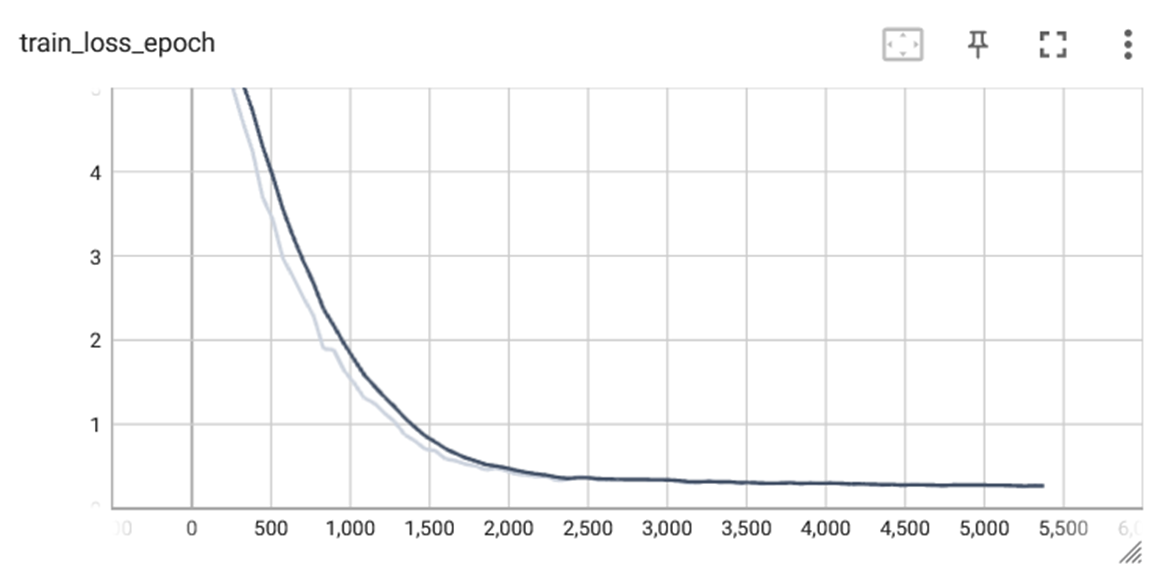
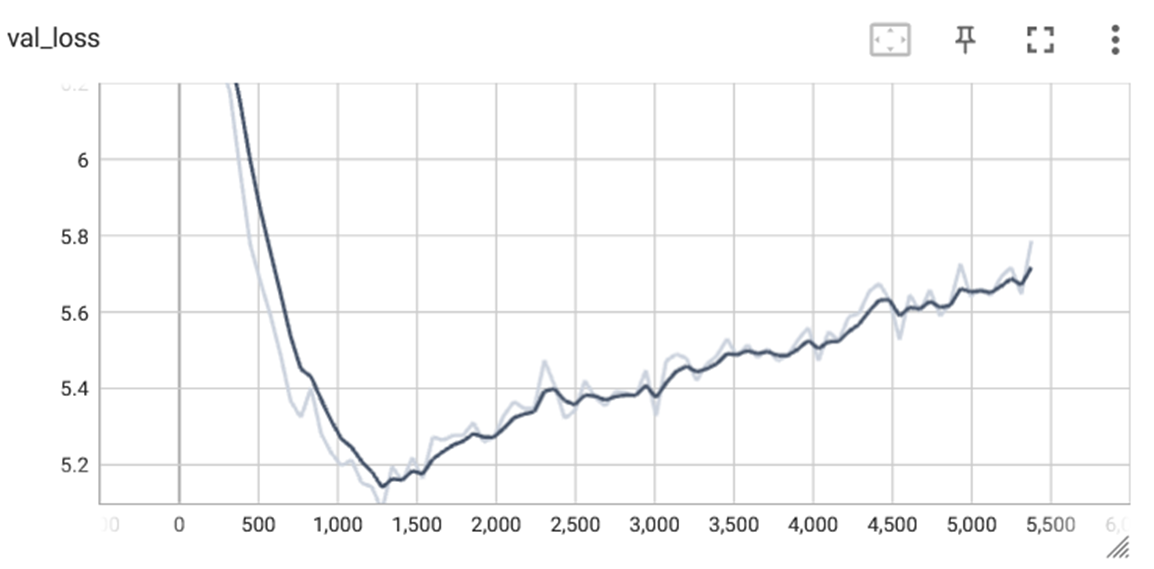

# Next.....
* Improvement of the English-to-Finnish translation model.
* Batch normalization
* Add an attention mechanism

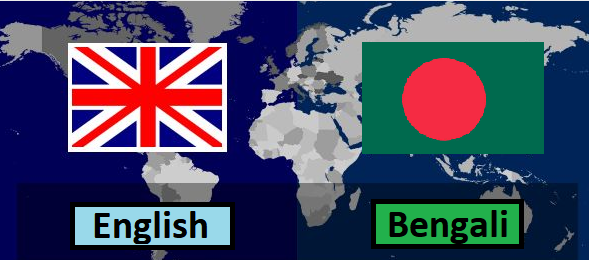